In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
np.set_printoptions(precision=3)

In [2]:
class Lcd(object):
  """An LCD like display.
  """
  
  def __init__(self, size=8):
    """Creates a blank size x size LCD like display.
    """
    self._size = size
    self._half = size / 2  # half size of the display
    self._last = size - 1  # index of the last row or col
    self.clear()
    
  def clear(self):
    """Clears this display"""
    self._display = np.zeros((self._size, self._size), dtype=np.int32)
    
  def show(self, digit):
    """Shows the given digit on the display.
    
    Args:
      digit: number
        the number to be shown on the display
    Returns:
      LCD this LCD display
    """
    self.clear()
    try:
      getattr(self, "_%s" % str(digit))()
      return self
    except AttributeError as e:
      raise NotImplementedError("Unable to render %s" % str(digit))
    
  def copyTo(self, mat, x, y):
    mat.fill(0)
    mat[x : x + self._size, y : y + self._size] = self._display

  def _0(self):
    self._display[0, :] = 1
    self._display[self._last, :] = 1
    self._display[:, 0] = 1
    self._display[:, self._last] = 1
    
  def _1(self):
    self._display[:, self._last] = 1
    
  def _2(self):
    self._display[0, :] = 1
    self._display[0 : self._half, self._last] = 1
    self._display[self._half, :] = 1
    self._display[self._last, :] = 1
    self._display[self._half : self._size, 0] = 1
    
  def _3(self):
    self._display[0, :] = 1
    self._display[self._half, :] = 1
    self._display[self._last, :] = 1
    self._display[:, self._last] = 1
    
  def _4(self):
    self._display[0 : self._half, 0] = 1
    self._display[self._half, :] = 1
    self._display[:, self._last] = 1

  def _5(self):
    self._display[0, :] = 1
    self._display[0 : self._half, 0] = 1
    self._display[self._half, :] = 1
    self._display[self._half : self._size, self._last] = 1    
    self._display[self._last, :] = 1
    
  def _6(self):
    self._display[:, 0] = 1
    self._display[self._half, :] = 1
    self._display[self._last, :] = 1
    self._display[self._half : self._size, self._last] = 1
    
  def _7(self):
    self._display[0, :] = 1
    self._display[:, self._last] = 1
    
  def _8(self):
    self._0()
    self._display[self._half, :] = 1
    
  def _9(self):
    self._7()
    self._display[self._half, :] = 1
    self._display[0 : self._half, 0] = 1
    
  def __str__(self):
    return str(self._display)

In [3]:
def GenerateImages(n, s, w, d):
  """Generates n random images of size s inside w x w matrix.
  
  Args:
    n: number
      The total number of images to generate
    s: number
      The size of the LCD.
    w: number
      The width and height of the matrix holding LCDs
    d: number
      The maximum number shown on any LCD
  Returns:
    ([n, w * w], [n]) a pair of flatten matrices with shapes and
    a vector indicating the kind of the shape.
  """
  if n <= 0:
    return None
  m = np.empty((0, w * w), dtype=np.int32)
  kind = []
  for i in range(n):
    v = np.zeros((w, w), dtype=np.int32)
    digit = np.random.randint(0, d + 1)
    sx = 0 if w == s else np.random.randint(0, w - s)
    sy = 0 if w == s else enp.random.randint(0, w - s)
    Lcd(s).show(digit).copyTo(v, sx, sy)
    m = np.append(m, v.reshape((1, w * w)), axis=0)
    k = [0] * (d + 1)
    k[digit] = 1
    kind.append(k)
  return (m, kind)

In [4]:
def ShowAsImages(v, pred_kind, kind_name, w):
  """Shows a binary, flat raster as an image.
  
  Args:
    v: np.array
      an array of bits.
    pred_kind: np.array
      an array of ints indicating the predicted image kind.
    kind_name: list[string]
      A list that has a string corresponding to each kind index.
    w: number
      the width and height of the image
  """
  n = len(v)
  s = np.int(np.sqrt(n))
  fig, axes = plt.subplots(s, s)
  fig.set_size_inches(2 * s, 2 * s)
  fig.subplots_adjust(hspace=.6, wspace=.3)
  
  for i, ax in enumerate(axes.flat):
    if i >= s * s: break
    inverted = (1 - v[i]).reshape((w, w))
    imgplot = ax.imshow(inverted, cmap=plt.cm.binary)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(kind_name[np.argmax(pred_kind[i])])
  plt.show()

In [5]:
# The width and the height of each image.
img_size = 5

# The size of each shape.
shape_size = 5

# The total number of training examples.
example_count = 500

# The number of digits (one more than the maximum digit).
kind_count = 10

# The names or labels for each kind:
kind_names = [str(x) for x in range(kind_count)]

In [6]:
img_data, true_kind = GenerateImages(example_count, shape_size, img_size, kind_count - 1)

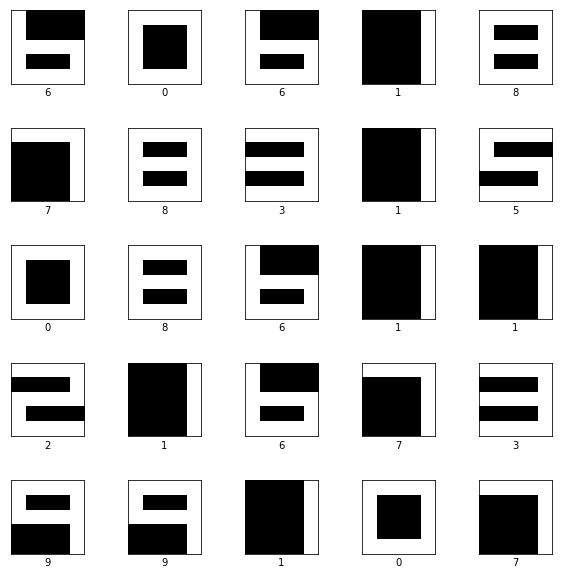

In [7]:
# Show the initial data. We have no predicated kind, so we use
# the true kind as both true and predicted kinds.
ShowAsImages(img_data[10 : 35, :], true_kind[10 : 35], kind_names, img_size)

In [8]:
# When learning we break data into batches. There are multiple benefits
# of doing this. First, the learning progresses faster. We do not have
# to learn from all examples, but rather from a small subset of them.
class BatchMaker(object):
  def __init__(self, img_data, kind, batch_size):
    self.img_data_ = img_data
    self.kind_ = kind
    self.batch_size_ = batch_size
    self.row_count_ = len(img_data)
    self.index_ = 0
    
  def next(self):
    img_slice = self.img_data_[self.index_ : self.index_ + self.batch_size_]
    kind_slice = self.kind_[self.index_ : self.index_ + self.batch_size_]
    self.index_ += self.batch_size_
    if self.index_ >= self.row_count_:
      self.index_ = 0
    return (img_slice, kind_slice)

In [9]:
# Learning parameters:

# The learning rate. Tells the optimizer how fast to follow the curve
# of the plane.
learning_rate = 0.3

# The number of images we look at a single step.
batch_size = 50

# The total number of steps we are going to run the learning step
step_count = 1000

In [10]:
# The placeholder for image bits. The first dimension is None to allow for any number
# of images. Each linear image is converted back to img_size x img_size  matrix.
x = tf.placeholder(tf.float32, shape=[None, img_size * img_size], name='x')

# The placeholder for true classes. This is what is going to drive neural network
# towards the correct solution.
y_true = tf.placeholder(tf.float32, shape=[None, kind_count], name='y_true')

In [11]:
def ComputeAccuracy(session, pred_kind, true_kind):
  """Computes accuracy of the given predictions
  
  Args:
    pred_kind: list[list[int]]
      1-hot encoded predicted kind for all examples.
    true_kind: list[list[int]]
      1-hot encoded true kind for all examples.
  Returns:
    float between 0 and 1 representing the accuracy of the predictions.
  """
  return np.mean(
    np.equal([np.argmax(r) for r in pred_kind], 
             [np.argmax(r) for r in true_kind]).astype(np.int32))

In [12]:
# Simple model. Multiply each flattened image by (img_size * img_size) x kind_count
# matrix. This produces a vector of size kind_count. Add bias to this vector and then
# use softmax cross entropy to assign a unique class to each result.
W = tf.Variable(tf.zeros([img_size * img_size, kind_count]), name="W")
b = tf.Variable(tf.zeros([kind_count]), name="b")

# Here y is the result of multiplying image data by weight matrix plus bias vector.
y = tf.matmul(x, W) + b
# The loss function tries to reduce mean between true labels and computed labels.
loss_fn = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y))

# The training step uses simple gradient descent that tries to minimize loss_fn.
# It takes
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_fn)

In [13]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
batch_maker = BatchMaker(img_data, true_kind, batch_size)

Accuracy 0.624


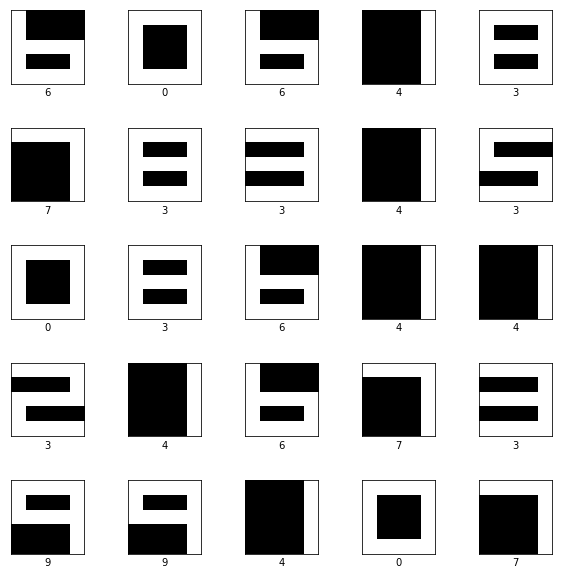

In [14]:
# Run the learning algorithm for 5 steps. Compute
# accuracy and print some predictions.
for _ in range(5):
  batch = batch_maker.next()
  train_step.run(feed_dict={x: batch[0], y_true: batch[1]})
  
# Compute current predictions.
pred_kind = sess.run(y, feed_dict={x: img_data})
  
print "Accuracy", ComputeAccuracy(sess, pred_kind, true_kind)
ShowAsImages(img_data[10 : 35, :],  pred_kind[10: 35], kind_names, img_size)

In [15]:
# Run the algorithm for the remaining step_count - 5 steps we already did.
for _ in range(step_count - 5):
  batch = batch_maker.next()
  train_step.run(feed_dict={x: batch[0], y_true: batch[1]})
# Compute final predictions.
pred_kind = y.eval(feed_dict={x: img_data})
# Compute final weight and biases.
W_final = sess.run(W)
b_final = sess.run(b)

In [16]:
print "Accuracy %.1f%%" % (100 * ComputeAccuracy(sess, pred_kind, true_kind))

Accuracy 100.0%


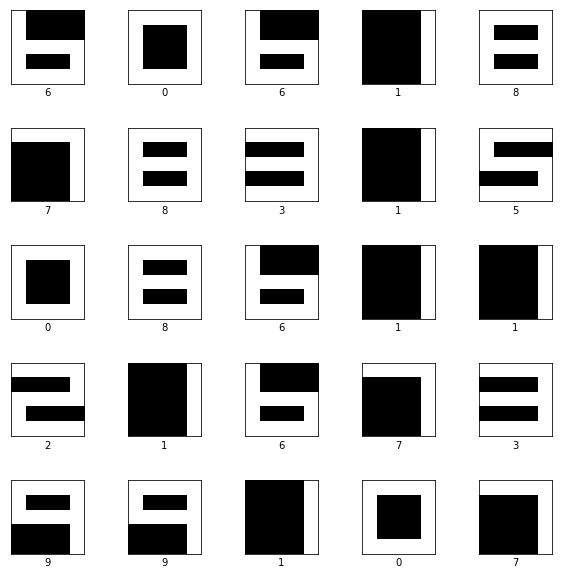

In [17]:
ShowAsImages(img_data[10 : 35, :], pred_kind[10 : 35], kind_names, img_size)

In [18]:
# Compute confusion matrix. If there are any errors, this shows us
# What confuses the model. For example, initially 3 and 8 might be
# considered very close.
cm = sess.run(tf.contrib.metrics.confusion_matrix(tf.argmax(pred_kind, 1), 
                                                  tf.argmax(true_kind, 1)))

In [19]:
sess.close()

[[44  0  0  0  0  0  0  0  0  0]
 [ 0 43  0  0  0  0  0  0  0  0]
 [ 0  0 44  0  0  0  0  0  0  0]
 [ 0  0  0 51  0  0  0  0  0  0]
 [ 0  0  0  0 52  0  0  0  0  0]
 [ 0  0  0  0  0 46  0  0  0  0]
 [ 0  0  0  0  0  0 57  0  0  0]
 [ 0  0  0  0  0  0  0 56  0  0]
 [ 0  0  0  0  0  0  0  0 55  0]
 [ 0  0  0  0  0  0  0  0  0 52]]


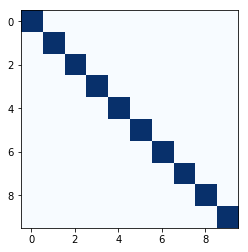

In [20]:
# Show the confusion matrix. We both show numeric values and
# heatmap representation.
print cm
cm_img = cm.astype(np.float32) / cm.sum(axis=1)
_ = plt.imshow(cm_img, interpolation='nearest', cmap=plt.cm.Blues)

In [21]:
def Explain(W, b, s):
  """Produces a series of images that explain how W favors given digit.
  
  Args:
    W: np.array((s * s, 10))
      The weights array.
    b: np.array(10)
      The bias vector
    s: number
      The size of the display.
  """
  col_dgt = []
  lcd = Lcd(s)
  for digit in range(10):
    v = np.matmul(lcd.show(digit)._display.reshape(1, s * s), W) + b
    col_dgt.append((np.argmax(v), str(digit)))
  fig, axes = plt.subplots(3, 4)
  fig.set_size_inches(9, 6)
  fig.subplots_adjust(hspace=.6, wspace=.3)
  for i, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])
    if i > 9:
      ax.axison=False
      continue
    # Pick the column that explains digit, reshaped as display.
    dm = W[:, col_dgt[i][0]].reshape((s, s))
    # Plot digit matrix normalized between 0 .. 1
    imgplot = ax.imshow((dm - dm.min()) / (dm.max() - dm.min()),
                        cmap=plt.cm.bwr)
    ax.set_xlabel(col_dgt[i][1])
  plt.show()

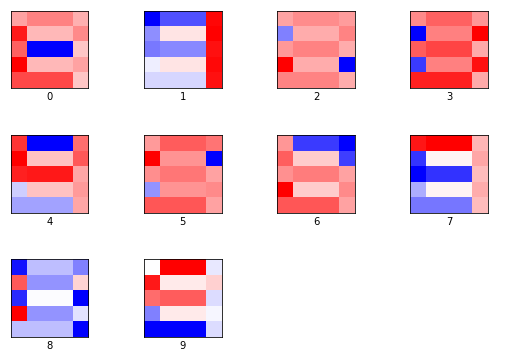

In [22]:
Explain(W_final, b_final, shape_size)

In [23]:
lcd = Lcd(shape_size)
for digit in range(kind_count):
  v = np.matmul(lcd.show(digit)._display.reshape(1, shape_size * shape_size), W_final) + b_final
  print np.argmax(v), ":", v
print
print "b :", b_final

0 : [[ 7.11  -1.096 -0.351 -0.987 -4.743 -0.18  -1.39   1.007  3.113 -2.483]]
1 : [[ 0.237  6.775 -2.979  0.672  1.687 -3.498 -2.307  2.125 -1.537 -1.174]]
2 : [[-0.368 -3.796  6.808  2.475 -3.252 -0.832 -0.993 -1.771  2.885 -1.155]]
3 : [[-1.422 -2.423  1.373  5.838 -2.444  1.32  -1.871 -0.852  1.008 -0.527]]
4 : [[-4.349  1.423 -3.576 -0.737  7.144 -1.225  0.609 -2.861  0.8    2.773]]
5 : [[-0.703 -4.341 -1.281  1.893 -1.964  6.223  0.374 -2.466  1.812  0.451]]
6 : [[-0.618 -2.573 -0.609 -1.108  2.156  2.241  8.322 -7.41   3.469 -3.871]]
7 : [[ 1.448  2.15  -1.89   1.271 -2.722 -1.956 -6.685  7.439 -1.521  2.467]]
8 : [[ 0.793 -3.39   0.977  0.375 -1.985  0.682  0.113 -2.557  5.2   -0.207]]
9 : [[-3.29  -1.727 -2.58  -0.059  1.968  0.383 -4.109  1.215  1.665  6.531]]

b : [-0.086  1.102  0.01  -0.33   0.147 -0.141  0.258  0.317 -0.975 -0.303]
